In [1]:
# Adapted from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
rootDirectory = '/content/drive/MyDrive/Colab Notebooks/FibreAnalysis/Data/synth'


In [ ]:
#!ls

#%cd /content/drive/MyDrive/Colab Notebooks
## Download the dataset
# !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# !unzip PennFudanPed.zip

 coco_eval.py	    'Initial RCNN Training attempt'   __pycache__
 coco_utils.py	     Mask_RCNN-master		      transforms.py
'Copy of Untitled'   Mask_RCNN-master_V2	      utils.py
 engine.py	     one.tif			      vision
 FibreAnalysis	     PennFudanPed
 foo.txt	     PennFudanPed.zip


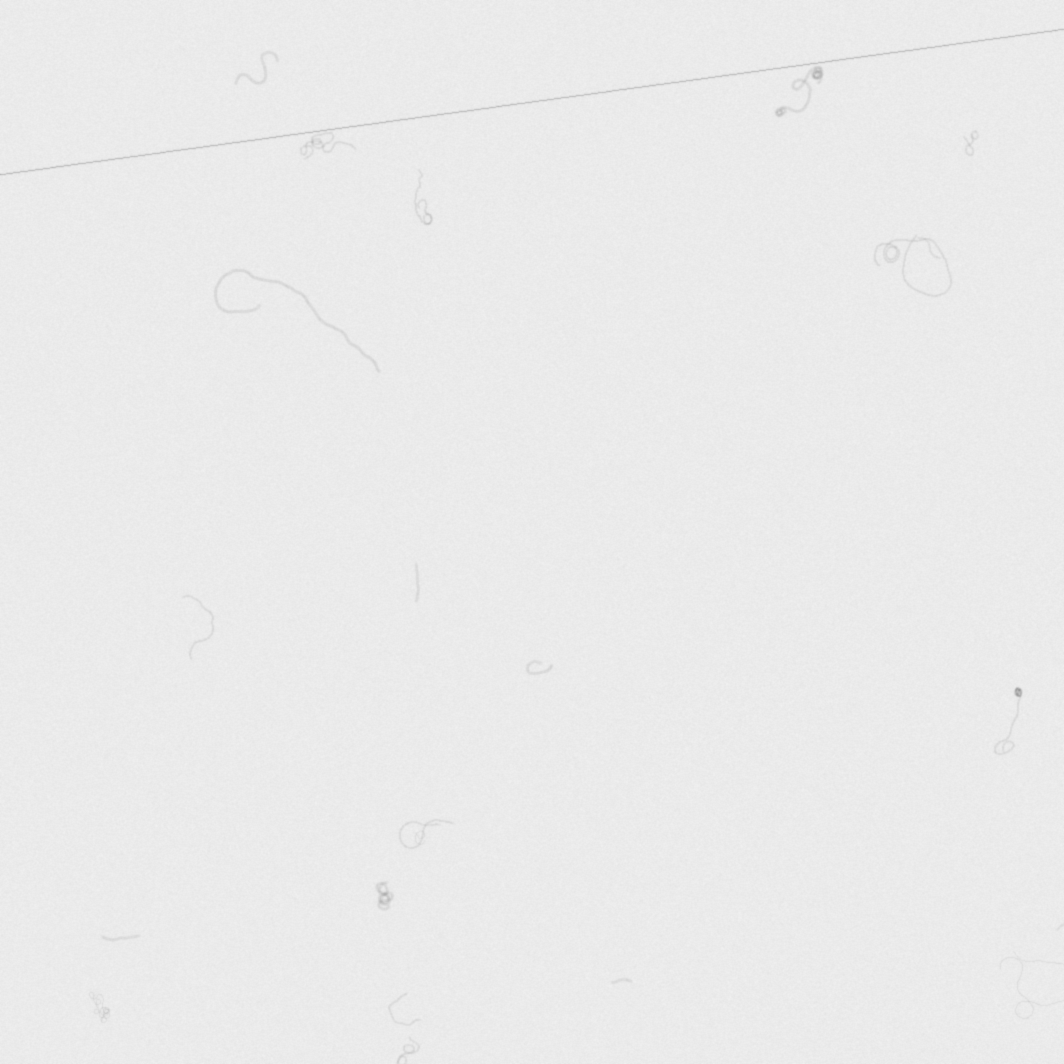

In [11]:
import os
from PIL import Image

image_path = os.path.join(rootDirectory, 'images' , 'image_2023-06-21_20-57-15-557748.png')
Image.open(image_path)



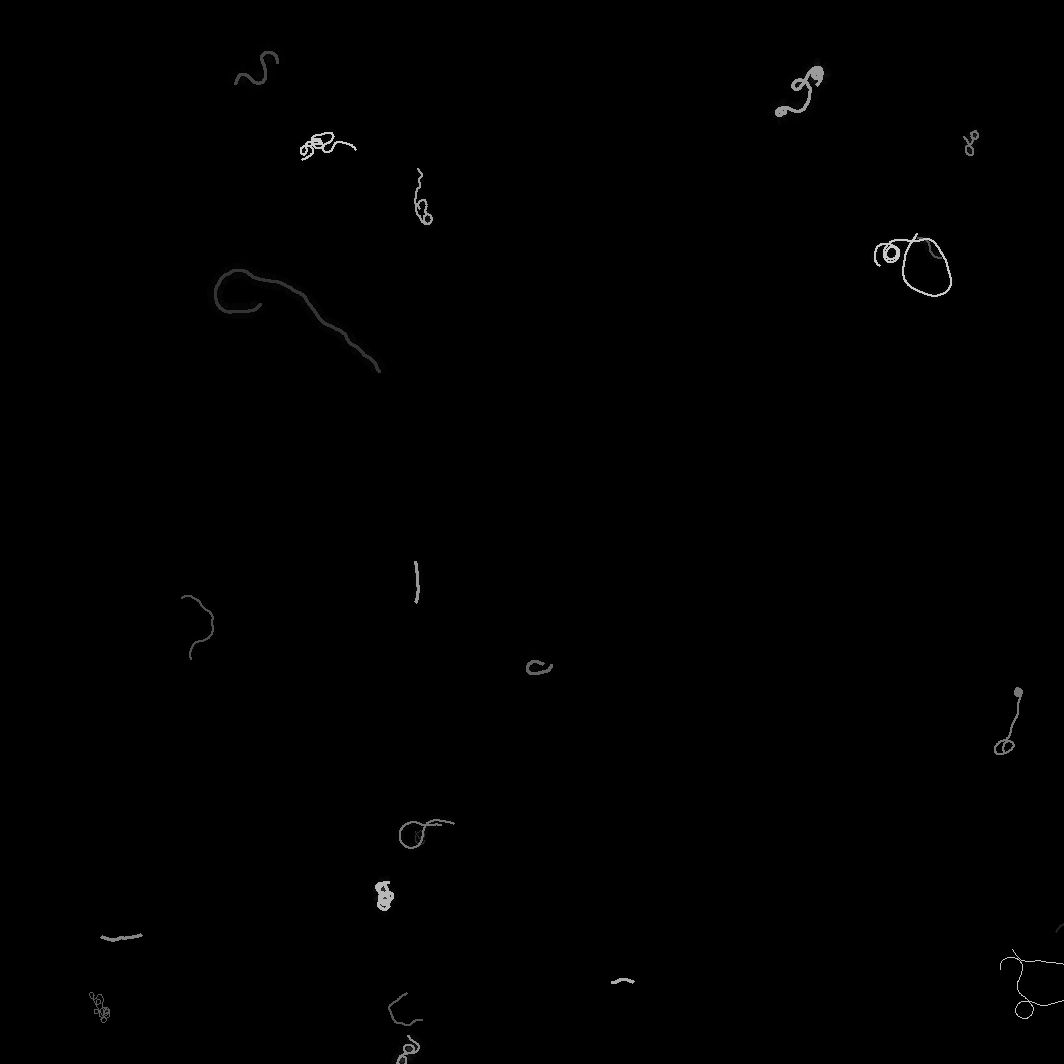

In [12]:
mask_path =  os.path.join(rootDirectory, 'masks' , 'mask_2023-06-21_20-57-15-557748.png')
Image.open(mask_path)

In [13]:

# Holding setup details, may not need these in future

# Tutorial is in https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# Download the required files form their git
# !git clone https://github.com/pytorch/vision.git
# !git stash
# !ls
# %cd vision
# !git stash
# !ls
# %cd vision
# !git checkout v0.3.0
# !ls
# !cp references/detection/utils.py ../               # Move required files into main directory
!echo $PYTHONPATH
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
 # Move required files into main directory
# !cp references/detection/utils.py ../../
# !cp references/detection/transforms.py ../
# !cp references/detection/coco_eval.py ../
# !cp references/detection/engine.py ../
# !cp references/detection/coco_utils.py ../
#%cd ..
%cd /content/drive/MyDrive/Colab Notebooks
!pwd

In [25]:
import os
import numpy as np
import torch
from PIL import Image


class SynthFibreDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [21]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks

# !pwd

# !ls

/content/drive/MyDrive/Colab Notebooks


To get import transfor to work - need to add the location of the transform.py to the sys path
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

In [22]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [27]:
import utils

In [28]:

# seems to be a check on existing performance
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = SynthFibreDataset(rootDirectory, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=2,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

AssertionError: ignored

In [ ]:
print(predictions)

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}, {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}]


In [33]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(device)
    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = SynthFibreDataset(rootDirectory, get_transform(train=True))
    dataset_test = SynthFibreDataset(rootDirectory, get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-10])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 2   # increase this later

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [34]:
main()

cuda


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 185MB/s]


AssertionError: ignored